<a href="https://colab.research.google.com/github/2003UJAN/Grad_Cam_Fashion_XAI/blob/main/Grad_Cam_Fashion_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8091526.78it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 62461.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 478262.91it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19558221.91it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
!pip install tensorflow numpy matplotlib


In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


Epoch [1/5], Step [100/938], Loss: 0.8322
Epoch [1/5], Step [200/938], Loss: 0.5008
Epoch [1/5], Step [300/938], Loss: 0.4445
Epoch [1/5], Step [400/938], Loss: 0.4064
Epoch [1/5], Step [500/938], Loss: 0.3801
Epoch [1/5], Step [600/938], Loss: 0.3587
Epoch [1/5], Step [700/938], Loss: 0.3553
Epoch [1/5], Step [800/938], Loss: 0.3195
Epoch [1/5], Step [900/938], Loss: 0.3272
Epoch [2/5], Step [100/938], Loss: 0.2884
Epoch [2/5], Step [200/938], Loss: 0.2898
Epoch [2/5], Step [300/938], Loss: 0.2867
Epoch [2/5], Step [400/938], Loss: 0.2803
Epoch [2/5], Step [500/938], Loss: 0.2968
Epoch [2/5], Step [600/938], Loss: 0.2774
Epoch [2/5], Step [700/938], Loss: 0.2732
Epoch [2/5], Step [800/938], Loss: 0.2587
Epoch [2/5], Step [900/938], Loss: 0.2607
Epoch [3/5], Step [100/938], Loss: 0.2495
Epoch [3/5], Step [200/938], Loss: 0.2412
Epoch [3/5], Step [300/938], Loss: 0.2353
Epoch [3/5], Step [400/938], Loss: 0.2148
Epoch [3/5], Step [500/938], Loss: 0.2349
Epoch [3/5], Step [600/938], Loss:

Epoch [1/5], Step [100/938], Loss: 0.8594
Epoch [1/5], Step [200/938], Loss: 0.4925
Epoch [1/5], Step [300/938], Loss: 0.4387
Epoch [1/5], Step [400/938], Loss: 0.4036
Epoch [1/5], Step [500/938], Loss: 0.3870
Epoch [1/5], Step [600/938], Loss: 0.3536
Epoch [1/5], Step [700/938], Loss: 0.3566
Epoch [1/5], Step [800/938], Loss: 0.3352
Epoch [1/5], Step [900/938], Loss: 0.3218
Epoch [2/5], Step [100/938], Loss: 0.3024
Epoch [2/5], Step [200/938], Loss: 0.2916
Epoch [2/5], Step [300/938], Loss: 0.2842
Epoch [2/5], Step [400/938], Loss: 0.2793
Epoch [2/5], Step [500/938], Loss: 0.2816
Epoch [2/5], Step [600/938], Loss: 0.2607
Epoch [2/5], Step [700/938], Loss: 0.2543
Epoch [2/5], Step [800/938], Loss: 0.2465
Epoch [2/5], Step [900/938], Loss: 0.2591
Epoch [3/5], Step [100/938], Loss: 0.2203
Epoch [3/5], Step [200/938], Loss: 0.2234
Epoch [3/5], Step [300/938], Loss: 0.2335
Epoch [3/5], Step [400/938], Loss: 0.2220
Epoch [3/5], Step [500/938], Loss: 0.2179
Epoch [3/5], Step [600/938], Loss:

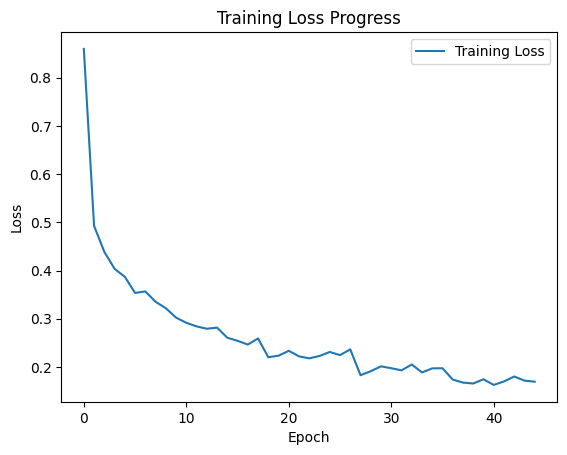

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
train_loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            train_loss_history.append(running_loss/100)
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Plot the training loss history
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.legend()
plt.show()


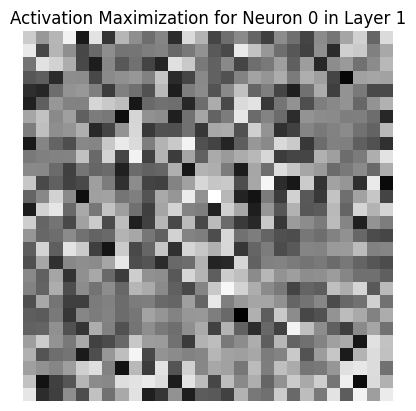

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model
model = SimpleCNN().to(device)

# Load pre-trained weights (optional)
# model.load_state_dict(torch.load("path_to_pretrained_weights.pth"))

# Function to perform activation maximization
def activation_maximization(model, layer_index, neuron_index, lr=0.1, iterations=100):
    image = torch.randn(1, 1, 28, 28, requires_grad=True, device=device)  # Random initialization of input image
    optimizer = optim.Adam([image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        output = model(image)
        activation = output[0, neuron_index]
        activation.backward()
        optimizer.step()

    return image.detach().cpu().numpy().squeeze()

# Choose layer and neuron index for activation maximization
layer_index = 1  # Index of the layer (e.g., conv1, conv2)
neuron_index = 0  # Index of the neuron in the layer

# Perform activation maximization
activated_image = activation_maximization(model, layer_index, neuron_index)

# Visualize the activated image
plt.imshow(activated_image, cmap='gray')
plt.axis('off')
plt.title(f'Activation Maximization for Neuron {neuron_index} in Layer {layer_index}')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


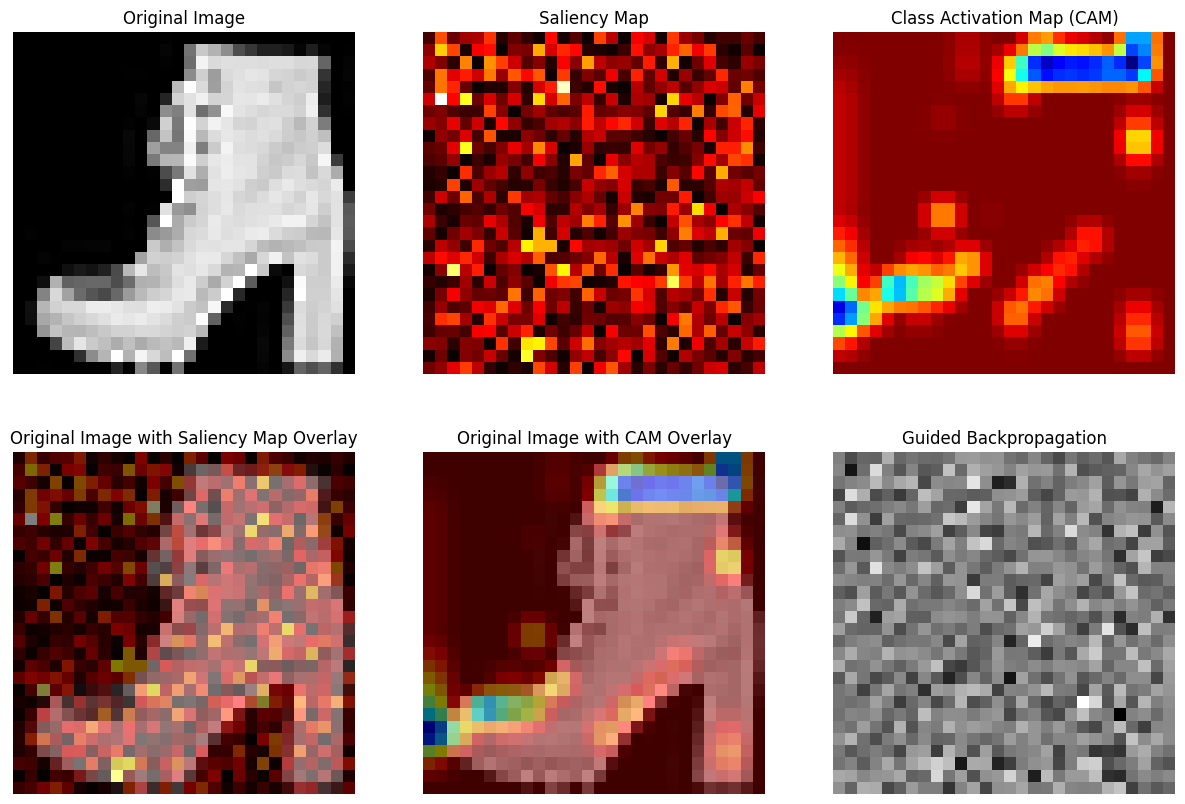

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Function to generate saliency maps
def generate_saliency_map(model, image, target_class=None):
    model.eval()
    image = image.to(device)
    image.requires_grad_()
    output = model(image)

    if target_class is None:
        target_class = output.argmax()

    model.zero_grad()
    output[0, target_class].backward()
    saliency_map = image.grad.abs().squeeze().detach().cpu()
    return saliency_map

# Function to generate Class Activation Maps (CAM)
class CAM:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None
        self.model_layer = model.conv2  # Adjust layer as per your model architecture

        self.model_layer.register_forward_hook(self.save_feature)
        self.model_layer.register_backward_hook(self.save_gradient)

    def save_feature(self, module, input, output):
        self.feature = output.cpu().data.numpy()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].cpu().data.numpy()

    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)  # Move to device

        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        gradient = self.gradient[0]
        weight = np.mean(gradient, axis=(1, 2))

        feature = self.feature[0]
        cam = np.zeros(feature.shape[1:], dtype=np.float32)

        for i, w in enumerate(weight):
            cam += w * feature[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

# Function for Guided Backpropagation
def guided_backprop(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad_()

    def hook_function(module, grad_in, grad_out):
        grad = grad_in[0]
        grad[grad > 0] = 1
        return grad

    hooks = []
    for module in model.named_modules():
        if isinstance(module[1], nn.ReLU):
            hooks.append(module[1].register_backward_hook(hook_function))

    output = model(image)
    model.zero_grad()
    output.backward(torch.ones_like(output))

    gradients = image.grad.detach().cpu().numpy().squeeze()
    return gradients

# Function to select a random image from the test set
def select_random_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    return image.unsqueeze(0), label

# Visualize all representations for a random image from the test set
images, labels = select_random_image(testset)
images = images.to(device)

# Initialize the model
model = SimpleCNN().to(device)

# Visualize all representations for a random image from the test set
original_image = images.squeeze().cpu().numpy()

# Saliency Map
saliency_map = generate_saliency_map(model, images)

# CAM
cam = CAM(model)
cam_map = cam(images)
cam_map = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
cam_map = np.float32(cam_map) / 255

# Guided Backpropagation
guided_backprop_map = guided_backprop(model, images)

# Visualization
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cam_map)
plt.title('Class Activation Map (CAM)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(original_image, cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title('Original Image with Saliency Map Overlay')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(original_image, cmap='gray')
plt.imshow(cam_map, alpha=0.5)
plt.title('Original Image with CAM Overlay')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(guided_backprop_map, cmap='gray')
plt.title('Guided Backpropagation')
plt.axis('off')

plt.show()


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=28be40d7f06004165e72aded43eed6fae1fc0d4298bdad14346f8d3094084dee
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Model loaded successfully.
Selected image: 981 Label: 9
Image loaded successfully.
Saliency map generated successfully.


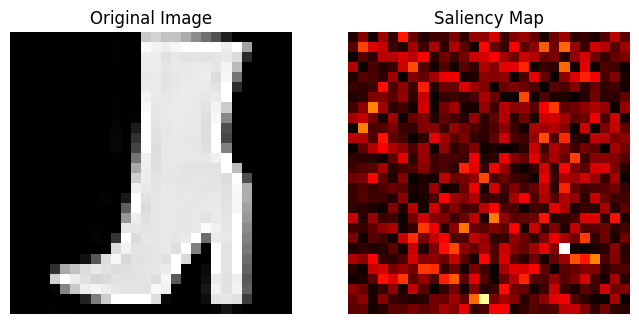

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Function to generate saliency maps
def generate_saliency_map(model, image, target_class=None):
    model.eval()
    image = image.to(device)
    image.requires_grad_()
    output = model(image)

    if target_class is None:
        target_class = output.argmax()

    model.zero_grad()
    output[0, target_class].backward()
    saliency_map = image.grad.abs().squeeze().detach().cpu()
    return saliency_map

# Function to select a random image from the test set
def select_random_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    print("Selected image:", idx, "Label:", label)
    return image.unsqueeze(0), label

# Load the model
model = SimpleCNN().to(device)
print("Model loaded successfully.")

# Select a random image from the test set
image, label = select_random_image(testset)
images = image.to(device)
print("Image loaded successfully.")

# Generate explanations
saliency_map = generate_saliency_map(model, images).detach().cpu().numpy()  # Detach the tensor and convert to numpy array
print("Saliency map generated successfully.")

# Plot the original image and saliency map
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(images.squeeze().detach().cpu().numpy(), cmap='gray')  # Detach the tensor before converting to numpy array
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.show()






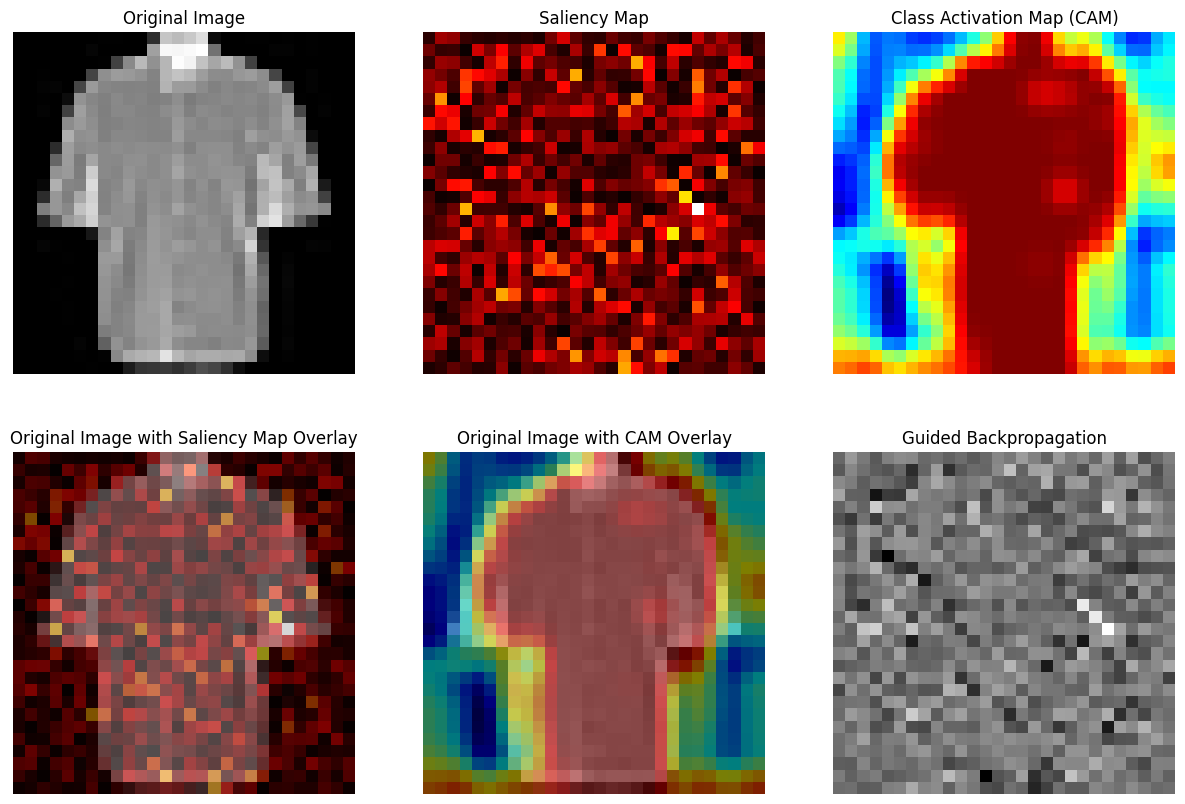

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Function to generate saliency maps
def generate_saliency_map(model, image, target_class=None):
    model.eval()
    image = image.to(device)
    image.requires_grad_()
    output = model(image)

    if target_class is None:
        target_class = output.argmax()

    model.zero_grad()
    output[0, target_class].backward()
    saliency_map = image.grad.abs().squeeze().detach().cpu()
    return saliency_map

# Function to generate Class Activation Maps (CAM)
class CAM:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None
        self.model_layer = model.conv2  # Adjust layer as per your model architecture

        self.model_layer.register_forward_hook(self.save_feature)
        self.model_layer.register_backward_hook(self.save_gradient)

    def save_feature(self, module, input, output):
        self.feature = output.cpu().data.numpy()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].cpu().data.numpy()

    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)  # Move to device

        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        gradient = self.gradient[0]
        weight = np.mean(gradient, axis=(1, 2))

        feature = self.feature[0]
        cam = np.zeros(feature.shape[1:], dtype=np.float32)

        for i, w in enumerate(weight):
            cam += w * feature[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

# Function for Guided Backpropagation
def guided_backprop(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad_()

    def hook_function(module, grad_in, grad_out):
        grad = grad_in[0]
        grad[grad > 0] = 1
        return grad

    hooks = []
    for module in model.named_modules():
        if isinstance(module[1], nn.ReLU):
            hooks.append(module[1].register_backward_hook(hook_function))

    output = model(image)
    model.zero_grad()
    output.backward(torch.ones_like(output))

    gradients = image.grad.detach().cpu().numpy().squeeze()
    return gradients

# Function to select a random image from the test set
def select_random_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    return image.unsqueeze(0), label

# Visualize all representations for a random image from the test set
images, labels = select_random_image(testset)
images = images.to(device)

# Initialize the model
model = SimpleCNN().to(device)

# Visualize all representations for a random image from the test set
original_image = images.squeeze().cpu().numpy()

# Saliency Map
saliency_map = generate_saliency_map(model, images)

# CAM
cam = CAM(model)
cam_map = cam(images)
cam_map = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
cam_map = np.float32(cam_map) / 255

# Guided Backpropagation
guided_backprop_map = guided_backprop(model, images)

# Visualization
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cam_map)
plt.title('Class Activation Map (CAM)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(original_image, cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title('Original Image with Saliency Map Overlay')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(original_image, cmap='gray')
plt.imshow(cam_map, alpha=0.5)
plt.title('Original Image with CAM Overlay')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(guided_backprop_map, cmap='gray')
plt.title('Guided Backpropagation')
plt.axis('off')

plt.show()


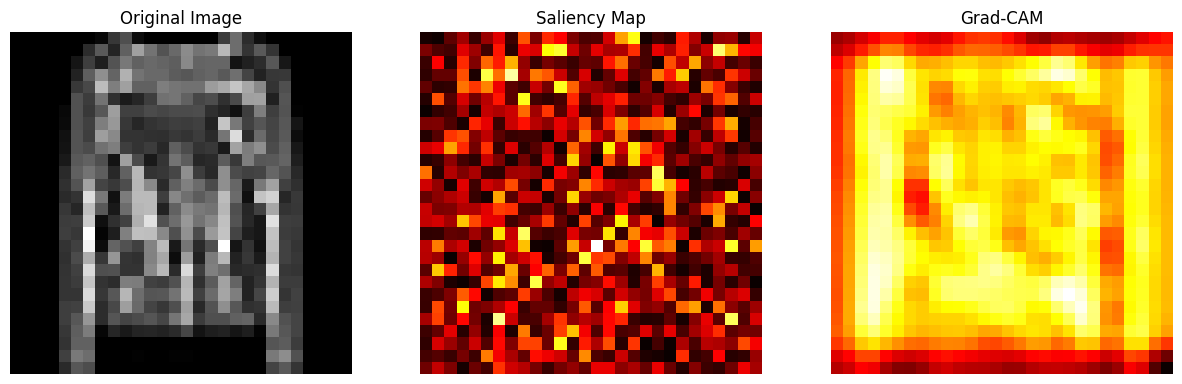

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjusted input size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Function to generate saliency maps
def generate_saliency_map(model, image, target_class=None):
    model.eval()
    image = image.to(device)
    image.requires_grad_()
    output = model(image)

    if target_class is None:
        target_class = output.argmax()

    model.zero_grad()
    output[0, target_class].backward()
    saliency_map = image.grad.abs().squeeze().detach().cpu()
    return saliency_map

# Function to generate Grad-CAM heatmap
class GradCAM:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None
        self.model_layer = model.conv2  # Adjust layer as per your model architecture

        self.model_layer.register_forward_hook(self.save_feature)
        self.model_layer.register_backward_hook(self.save_gradient)

    def save_feature(self, module, input, output):
        self.feature = output.cpu().data.numpy()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].cpu().data.numpy()

    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)  # Move to device

        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        gradient = self.gradient[0]
        weight = np.mean(gradient, axis=(1, 2))

        feature = self.feature[0]
        cam = np.zeros(feature.shape[1:], dtype=np.float32)

        for i, w in enumerate(weight):
            cam += w * feature[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

# Function to select a random image from the test set
def select_random_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    return image.unsqueeze(0), label

# Visualize all representations for a random image from the test set
images, labels = select_random_image(testset)
images = images.to(device)

# Initialize the model
model = SimpleCNN().to(device)

# Visualize all representations for a random image from the test set
original_image = images.squeeze().cpu().numpy()

# Saliency Map
saliency_map = generate_saliency_map(model, images)

# Grad-CAM
grad_cam = GradCAM(model)
grad_cam_map = grad_cam(images)

# Visualization
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(grad_cam_map, cmap='hot')
plt.title('Grad-CAM')
plt.axis('off')

plt.show()
